In [9]:
import numpy as np
import Agents
from sweeper import Sweeper
from training_engine import ConfigDictConverter, test_policy_evaluation_error
import pickle
import matplotlib.pyplot as plt
import offline_data

np.set_printoptions(precision=3, linewidth=300, suppress=True)

i_run = 0
sweeper = Sweeper('config/config_other.json')

# do some training here
config_dict = sweeper.parse(i_run)
cfg = ConfigDictConverter(config_dict)

chkpt_idx = 0

td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
td_model_path = 'test_save_mountain/td_0_model_{chkpt_idx}.pyt'  # not an f-string so we can vary chkpt_idx later
# td_agent.load_model(f'test_save_mountain/td_0_model_{chkpt_idx}.pyt')


mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
mc_model_path = 'test_save_mountain/mc_0_model_{chkpt_idx}.pyt'
# mc_agent.load_model(f'test_save_mountain/mc_0_model_{chkpt_idx}.pyt')

path = 'data_generation/'
# test_states = np.load(path + 'Cartpole_test_states_0.npy')
# test_values = np.load(path + 'Cartpole_test_values_0.npy')
test_states = offline_data.load_test_states(path, "mountaincar")  # moutn
test_values = offline_data.load_test_values(path, "mountaincar")





TDPolicyEval


In [10]:
### Compute linear regression error

# print(len(test_values), all_features.shape)
# print(agent.get_prediction(test_states[0]), test_values[0])
def test_error(agent, verbose=True):
    # preds = agent.get_prediction(test_states)
    # print(preds)
    # rmse = np.sqrt(np.mean((preds - test_values)**2))
    rmse = test_policy_evaluation_error(agent, test_states, test_values)
    if verbose:
        print("test error", rmse)
    return rmse


def linear_regression_test(agent, verbose=True):
    all_features = agent.get_features(test_states)
    param, squared_error, rank, _ = np.linalg.lstsq(all_features, test_values, rcond=None)
    
    linear_test_error = np.sqrt(np.mean( (np.dot(all_features, param) - test_values)**2))
    if verbose:
        print("feature rank", rank)
        print("linear test error", linear_test_error)
    return rank, linear_test_error
    

def compare_TD_and_MC(chkpt_idx, verbose=True):
    td_agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
    td_agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))

    mc_agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
    mc_agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
    
    if verbose:
        print("--- TD Agent --- checkpoint", chkpt_idx)
    test_error_td = test_error(td_agent, verbose)
    rank_td, lin_test_error_td = linear_regression_test(td_agent, verbose)
    if verbose:
        print("--- MC Agent ---")
    test_error_mc = test_error(mc_agent, verbose)
    rank_mc, lin_test_error_mc = linear_regression_test(mc_agent, verbose)
    return test_error_td, rank_td, lin_test_error_td, test_error_mc, rank_mc, lin_test_error_mc

_ = compare_TD_and_MC(199)
_ = compare_TD_and_MC(2099)

--- TD Agent --- checkpoint 199
test error 62.88532625487942
feature rank 56
linear test error 8.777769103154661
--- MC Agent ---
test error 16.008488387223977
feature rank 56
linear test error 10.513760612669993
--- TD Agent --- checkpoint 2099
test error 8.882424678411212
feature rank 49
linear test error 6.780309717416854
--- MC Agent ---
test error 8.423311591975486
feature rank 56
linear test error 6.294912355950135


[   0   99  199  299  399  499  599  699  799  899  999 1099 1199 1299 1399 1499 1599 1699 1799 1899 1999 2099 2199 2299 2399 2499 2599 2699 2799 2899 2999 3099 3199 3299 3399 3499 3599 3699 3799 3899 3999 4099 4199 4299 4399 4499 4599 4699 4799 4899 4999]


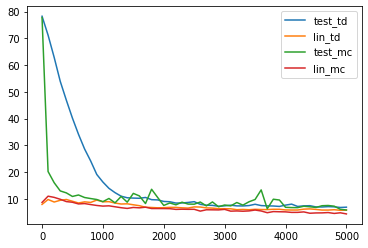

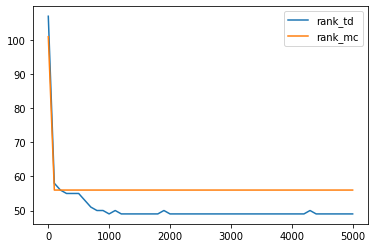

In [11]:
idxs = np.arange(0, 50)*100 + 99
idxs = np.insert(idxs,0,0)
print(idxs)
results = []
for idx in idxs:
    results.append(compare_TD_and_MC(idx, verbose=False))
results = np.array(results)

plt.plot(idxs, results[:,0], label='test_td')
plt.plot(idxs, results[:,2], label='lin_td')

plt.plot(idxs, results[:,3], label='test_mc')
plt.plot(idxs, results[:,5], label='lin_mc')
plt.legend()

plt.figure()
plt.plot(idxs, results[:,1], label='rank_td')
plt.plot(idxs, results[:,4], label='rank_mc')
plt.legend()


In [ ]:
### Compute alignment as in Ehsan's paper
def compute_alignment(singular_vectors, y, singular_values, threshold):
    ''' Computes the alignment for the specified threshold 
    We rescale the singular values by the largest singular value. This ensures that the convergence rate
    bounds are comparable. See Ehsan's paper.'''
    scaled_singular_values = singular_values / np.max(singular_values)
    threshold_idx = np.searchsorted(-scaled_singular_values, -threshold)  # gives first index where value exceeds threshold
    alignments = np.transpose(singular_vectors[:, 0:threshold_idx]).dot(y)
    return np.sum(alignments**2)

chkpt_idx = None
def plot_alignment(chkpt_idx, model):
    if model == 'td':
        agent = Agents.OfflinePolicyEvalTDAgent(**cfg.config_dict)
        agent.load_model(td_model_path.format(chkpt_idx=chkpt_idx))
    elif model == 'mc':
        agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)
        agent.load_model(mc_model_path.format(chkpt_idx=chkpt_idx))
    elif model == 'random':
        agent = Agents.OfflinePolicyEvalMCAgent(**cfg.config_dict)  # random untrained agent

    features = agent.get_features(test_states, add_bias=True)

    print("max feature", np.max(features), "max l2", np.max(np.linalg.norm(features,ord=2, axis=1)),
         "max l1", np.max(np.linalg.norm(features,ord=1, axis=1)))

    # scaled_features = features #/  np.max(np.linalg.norm(features,ord=2, axis=1)) # / np.max(features)

    singular_vectors, singular_values, _ = np.linalg.svd(features)
    print("singular values", singular_values[0:20])

    alignments = []
    thresholds = np.linspace(0, 1.01, 100)

    for x in thresholds:
        alignments.append(compute_alignment(singular_vectors, test_values/100, singular_values, x))
    
    print("Avg alignment", np.mean(alignments))
    plt.plot(thresholds, alignments, label=model+str(chkpt_idx))
    plt.ylim(150,350)

# how to summarize these 

max feature 4.681591 max l2 13.137147 max l1 86.99248
singular values [156.785  62.781  34.033  18.96   14.942  11.971   6.4     5.841   5.597   3.557   3.315   2.799   2.486   2.283   2.015   1.776   1.631   1.368   1.251   1.131]
Avg alignment 218.35116006315198
max feature 5.554041 max l2 16.899557 max l1 93.50393
singular values [283.621  58.731  39.291  17.648  14.612  10.786   9.383   6.687   4.775   3.583   3.192   2.878   2.487   2.082   1.973   1.719   1.448   1.293   1.127   0.969]
Avg alignment 248.9947526705602
max feature 6.5209684 max l2 22.048018 max l1 121.41485
singular values [397.098  61.155  49.282  30.137  17.986  13.397  10.235   8.391   4.641   4.406   3.873   3.106   2.692   2.389   1.979   1.866   1.692   1.461   1.256   1.127]
Avg alignment 262.26940136781246
max feature 8.250406 max l2 31.013184 max l1 191.21259
singular values [549.826 120.054  80.015  42.118  29.117  23.641  16.751  14.527  12.231   9.973   6.196   4.79    4.608   3.907   3.48    2.657   2.

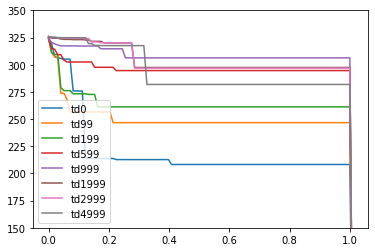

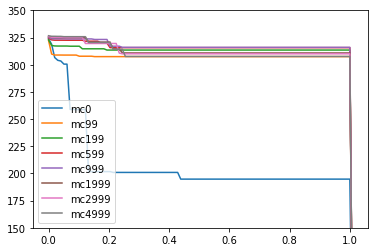

In [12]:
idxs = [0,99, 199, 599, 999, 1999, 2999, 4999]
for idx in idxs:
    plot_alignment(idx, 'td')
plt.legend()
plt.figure()
for idx in idxs:
    plot_alignment(idx, 'mc')
plt.legend()

max feature 3.172454 max l2 10.367496 max l1 69.35951
singular values [135.07   57.652  30.41   19.157  15.36   10.311   7.299   6.24    5.351   3.903   3.29    2.888   2.592   2.368   1.849   1.643   1.545   1.364   1.271   1.165]
Avg alignment 208.64396681731358


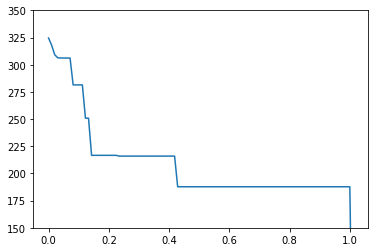

In [13]:
plot_alignment(0, model='random')

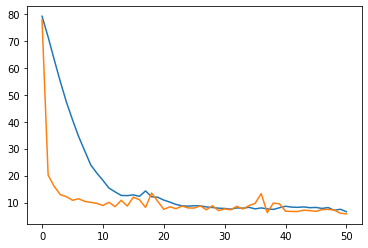

In [23]:
with open("test_save_mountain/td_0.pkl", 'rb') as file:
    td_results = pickle.load(file)
plt.plot(td_results['test_error'])
# print(results['test_error'])
with open("test_save_mountain/mc_0.pkl", 'rb') as file:
    mc_results = pickle.load(file)
plt.plot(mc_results['test_error'])